In [1]:
%matplotlib inline

## Synthetic DATA


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image

from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/torchsample-0.1.2-py3.6.egg/torchsample/datasets.py:16: UserWarning: Cant import nibabel.. Cant load brain images


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ts_transforms.TypeCast('float'), 
        #ts_transforms.ChannelsFirst(),
        ts_transforms.RangeNorm(0,1),
        ts_transforms.RandomRotate(30),
        ts_transforms.RandomGamma(.2,1.8),
        ts_transforms.RandomSaturation(.5,.9),
        ts_transforms.RandomBrightness(-.2,.2)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        ts_transforms.TypeCast('float'), 
        #ts_transforms.ChannelsFirst(),
        ts_transforms.RangeNorm(0,1)
    ]),
}
'''

rootdir='//media//mtezcan//New Volume/HoardingImages//_rated//'
valdir='//media//mtezcan//New Volume/HoardingImages//_val//House//LR'
subdirs=os.listdir(rootdir)
print(subdirs)
roomdirs=['//BR','//Kitchen','//LR']
data_dir = '..//Data_Sets//pruned//good'
#dsets = {x: datasets.ImageFolder_mtezcan([os.path.join(data_dir, x)], data_transforms[x])
#         for x in ['train', 'val']}

dsets = {'train':datasets.ImageFolder_mtezcan([rootdir+subdir+room for subdir in subdirs
                                               for room in roomdirs], data_transforms['train']),
         'val':datasets.ImageFolder_mtezcan([valdir], data_transforms['val'])}
 

weights,wpc = ft.make_weights_for_balanced_classes(dsets['train'].imgs, len(dsets['train'].classes))  
print(wpc)
weights = torch.DoubleTensor(weights) 
#sampler = {'train':torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) ,
sampler = {'train':None,
           'val':None}
shuffler={'train':False,'val':False}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x], batch_size=32,shuffle=shuffler[x],sampler=sampler[x], num_workers=4)
                for x in ['train','val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print(dset_classes)
use_gpu = torch.cuda.is_available()

#use_gpu=False
if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

['BasicHouse_2017-07-01-rated', 'BriansHouse_2017-06-30-rated', 'RuralHome_2017-06-30-rated', 'SmallApt_2017-06-29-rated']
65184
62472
0
50358
50520
49830
46044
43986
41472
51348
42805
41620
545639
57156
57156
[28.34341073191003, 11.044876725638638, 9.330192712162924, 7.0193094398847355, 4.728732623843034, 11.326891140081376, 7.984999926828912, 8.246765612719908, 12.774242637074495]
['1', '2', '3', '4', '5', '6', '7', '8', '9']
GPU is available


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 1810, 906])


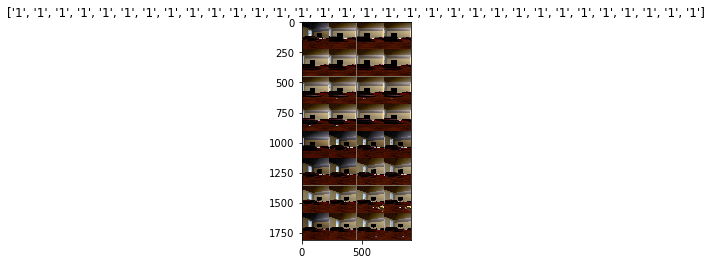

In [4]:

inputs, classes = next(iter(dset_loaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=4)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
ft.imshow(out, title=[dset_classes[x] for x in classes])

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [5]:
model_ft = models.resnet18(pretrained=True)
#model_ft=torch.load('./saved_models/resnet_synthetic_7_8_17.mdl')
#print('The CNN model is')
#print(model_ft)
#print(list(model_ft.children())[:-1])
num_ftrs = model_ft.fc.in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
#setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
model_ft.fc = nn.Linear(num_ftrs, 9)
#print(model_ft)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters())
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Number of features in the fine tune layer is 512


In [ ]:
model_ft = models.alexnet(pretrained=True)

#print('The CNN model is')
print(model_ft)
#print(list(model_ft.children())[:-1])
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.fc = nn.Linear(num_ftrs, 9)
#print(model_ft)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [7]:
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = ft.train_model(model_ft, criterion, optimizer_ft, ft.exp_lr_scheduler,dset_loaders,use_gpu=use_gpu,
                       num_epochs=20,batch_size=32,num_log=50)

Epoch 0/19
----------
LR is set to 0.001
50/17052, CIR-1: 0.9800


Process Process-10:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Process Process-11:
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-12:
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mtezcan/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/mtezcan/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/mtezcan/anaconda3/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "

In [ ]:
torch.save(model_ft,'./saved_models/resnet_synthetic_7_8_17.mdl')

# --- to-be-optimized ---

In [ ]:
#print(next(iter(dset_loaders['train']))[0])
#model_ft = models.alexnet(pretrained=True)

model_ft=model_ft.cpu()
#new_classifier = nn.Sequential(*list(model_ft.classifier.children())[:-5])
#model_ft.classifier = new_classifier
#print(model_ft)
model_params= list(model_ft.children())
#model_params[1]=list(model_params[1])
#print(model_params)
new_ft = nn.Sequential(*list(model_params)[:-1])
#print(new_ft)

fvec_tr=np.zeros((20000,512))
label_tr=np.zeros((20000))

fvec_val=np.zeros((20000,512))
label_val=np.zeros((20000))
count=0;

#inputs_t, classes_t = data=next(iter(dset_loaders['train']))
#print(inputs_t.size())
#fvec_t=new_ft(Variable(inputs_t))

for data in dset_loaders['train']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    #print(fvec_t)
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_tr[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_tr[count:count+4]=classes_t.short().numpy()
        count +=4
fvec_tr=fvec_tr[:count,:]
label_tr=label_tr[:count]


count=0;
for data in dset_loaders['val']:
    inputs_t, classes_t = data
    fvec_t=new_ft(Variable(inputs_t))
    fvec_t_cpu=fvec_t.cpu()
    if(fvec_t_cpu.data.numpy().shape[0]==4):
        fvec_val[count:count+4,:]=fvec_t_cpu.data.numpy().reshape(4,-1)
        label_val[count:count+4]=classes_t.short().numpy()
        count +=4
    
fvec_val=fvec_val[:count,:]
label_val=label_val[:count]

'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

print('Size of the input in training is '+str(fvec_tr.shape))
print('Size of the labels in training is '+str(label_tr.shape))

print('Size of the input in validation is '+str(fvec_val.shape))
print('Size of the labels in validation is '+str(label_val.shape))


In [ ]:
print(fvec_val.shape)
print(fvec_val[1,:])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
#clf = SVC(C=1,kernel='linear',class_weight='balanced',decision_function_shape='ovo')
clf=OneVsOneClassifier(LinearSVC(C=1))
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
cir1=np.mean(abs_err<=1)
print(cir1)

In [ ]:
from sklearn.svm import SVC

c_val=np.power(2,np.arange(0.,8.,1.))
g_val=np.power(2,np.arange(-8.,0.,1.))

#c_val=[1e-10]
#g_val=[np.power(2,-7.)]
cir1_max=0.
c_max=0
g_max=0
for c_1 in c_val:
    for g in g_val:
        
        clf_svc = SVC(C=c_1,kernel='rbf',gamma=g,shrinking=False,class_weight='balanced')
        clf=OneVsOneClassifier(clf_svc)
        #print(label_tr)
        clf.fit(fvec_tr,label_tr)

        label_pred=clf.predict(fvec_val)
        #print(label_pred)
        abs_err=np.abs(label_pred-label_val)
        #print(abs_err)
        cir1=np.mean(abs_err<=1)
        print('C = '+str(c_1),', g = ',str(g),', cir-1 = '+str(cir1))
        if(cir1>cir1_max):
            cir1_max=cir1
            c_max=c_1
            g_max=g
            

clf = SVC(C=c_max,kernel='linear',gamma=g_max)#,class_weight='balanced')
clf.fit(fvec_tr,label_tr)
label_pred=clf.predict(fvec_val)
abs_err=np.abs(label_pred-label_val)
print('Max CIR-1 achieved is '+str(np.mean(abs_err<=1)) +' with c='+str(c_max),', g='+str(g_max))
print('CIR-0 = '+str(np.mean(abs_err<=0)))
print('CIR-2 = '+str(np.mean(abs_err<=2)))
print(abs_err)
print(label_val)

In [ ]:
model_ft = models.resnet18(pretrained=True)

#print('The CNN model is')
#print(model_ft)
#print(list(model_ft.children())[:-1])
num_ftrs = model_ft.fc.in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
#setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
model_ft.fc = nn.Linear(num_ftrs, 9)
#print(model_ft)

#print(next(iter(dset_loaders['train']))[0])
new_ft = nn.Sequential(*list(model_ft.children())[:-1])
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

fvec_tr=np.zeros((X_tr.shape[0],512))
for k in range(0,10,10):#(0,inputs.shape[0],10):
    print(k)
    fvec_now=new_ft(Variable(torch.from_numpy(X_tr[k:k+10,:,:,:])))
    print(fvec_now.numpy())

print(fvec)


'''
print('The CNN model is')
print(model_ft)
num_ftrs = model_ft.classifier[6].in_features
print('Number of features in the fine tune layer is '+str(num_ftrs))
setattr(model_ft.classifier, '6', nn.Linear(num_ftrs, 9))
#model_ft.classifier['6'] = nn.Linear(num_ftrs, 2)
print(model_ft)
'''

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    #print(param)
    param.requires_grad = False
    
for param in model_conv.fc.parameters():
    #print(param)
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 9)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()